# TIGRESS 21-cm `caribou_hi` Results
Trey Wenger - September 2024

Inspect `caribou_hi` results.

## Load synthetic data

In [269]:
import pickle

resultsdir = "/media/drive1/tigress_results/R8_4pc_MHD_PI"

with open(f"{resultsdir}/HI_joint_spectra.pkl", "rb") as f:
    synth_data = pickle.load(f)

## Load simulation data

In [3]:
import numpy as np

sim_phases = {
    "All": {"color": "black", "temp_min": 0.0, "temp_max": np.inf},
    "CNM": {"color": "blue", "temp_min": 0.0, "temp_max": 500.0},
    "LNM": {"color": "green", "temp_min": 500.0, "temp_max": 5000.0},
    "WNM": {"color": "orange", "temp_min": 5000.0, "temp_max": np.inf},
}

In [6]:
from astropy.io import fits

# Assumed CMB background brightness temperature
Tcmb = 2.7

# Assumed ON source brightness temperature
Tbg = 1000.0

# Assumed filling factor
filling_factor = 1.0

# load physical properties
with fits.open(f"{resultsdir}/velocity.fits") as hdulist:
    sim_velocity = hdulist[0].data
with fits.open(f"{resultsdir}/spin_temperature.fits") as hdulist:
    sim_spin_temp = hdulist[0].data
with fits.open(f"{resultsdir}/kinetic_temperature.fits") as hdulist:
    sim_kin_temp = hdulist[0].data
with fits.open(f"{resultsdir}/pressure.fits") as hdulist:
    sim_pressure = hdulist[0].data
for phase in sim_phases.keys():
    with fits.open(f"{resultsdir}/nHI_{phase}.fits") as hdulist:
        sim_phases[phase]["nHI"] = hdulist[0].data
    with fits.open(f"{resultsdir}/NHI_{phase}.fits") as hdulist:
        sim_phases[phase]["NHI"] = hdulist[0].data
        
# resolution
res = 4.0 # pc

# path length along observed (y) axis
depth = np.arange(sim_velocity.shape[1]) * res # pc

# load radiative transfer output
for phase in sim_phases.keys():
    with fits.open(f"{resultsdir}/HI_{phase}_TB_on.fits") as hdulist:
        sim_phases[phase]["TB_on"] = hdulist[0].data
    with fits.open(f"{resultsdir}/HI_{phase}_TB_off.fits") as hdulist:
        sim_phases[phase]["TB_off"] = hdulist[0].data

    # emission spectra
    sim_phases[phase]["emission"] = sim_phases[phase]["TB_off"] - Tcmb

    # absorption spectra
    sim_phases[phase]["absorption"] = -np.log(
        (sim_phases[phase]["TB_on"] - sim_phases[phase]["TB_off"]) / Tbg
    )

## Inspect a single result

In [260]:
import dill

# get random result
# idx = np.random.choice(list(results.keys()))
# while synth_data["data_list"][idx].max() < 0.01:
#     idx = np.random.choice(list(results.keys()))
idx = 18710

results = {}
with open(f"{resultsdir}/HI_joint_spectra_results/{idx}_pencilbeam.pkl", "rb") as f:
    results[idx] = dill.load(f)

In [261]:
# get best model
print(f"idx = {idx}")
print("n_cloud, BIC, max(r_hat)")
best_bic = np.inf
best_n_gauss = 0
best_solution = 0
for n_gauss in results[idx]["results"].keys():
    bic = np.nan
    max_rhat = np.nan
    if "bic" in results[idx]["results"][n_gauss]:
        bic = results[idx]["results"][n_gauss]["bic"]
    if "solutions" in results[idx]["results"][n_gauss].keys():
        for solution in results[idx]["results"][n_gauss]["solutions"].keys():
            if results[idx]["results"][n_gauss]["solutions"][solution]["bic"] == bic:
                max_rhat = results[idx]["results"][n_gauss]["solutions"][solution]["summary"]["r_hat"].max()
                break
    if bic < (best_bic - 10.0) and max_rhat < 1.05:
        best_n_gauss = n_gauss
        best_bic = bic
        best_solution = solution
    print(n_gauss, bic, max_rhat)
print(f"Best n_gauss = {best_n_gauss}")
print(f"Best solution = {best_solution}")

idx = 18710
n_cloud, BIC, max(r_hat)
0 4287777.590576107 nan
1 1997.379772318702 1.0
2 -4756.416740811299 1.03
3 -4869.485633320755 1.01
4 -4915.545439467487 1.01
5 inf nan
6 inf nan
7 inf nan
8 inf nan
Best n_gauss = 4
Best solution = 0


In [262]:
import arviz as az

trace = az.extract(results[idx]["results"][best_n_gauss]["solutions"][best_solution]["trace"])

# evaluate posterior predictive samples
absorption_optical_depth = physics.calc_optical_depth(
    synth_data["x_values"][idx][:, None],
    trace["velocity"].data.T,
    10.0 ** trace["log10_NHI"].data.T,
    trace["tspin"].data.T,
    trace["fwhm"].data.T,
).eval()

emission_optical_depth = physics.calc_optical_depth(
    synth_data["x_values_em"][idx][:, None],
    trace["velocity"].data.T,
    10.0 ** trace["log10_NHI"].data.T,
    trace["tspin"].data.T,
    trace["fwhm"].data.T,
).eval()

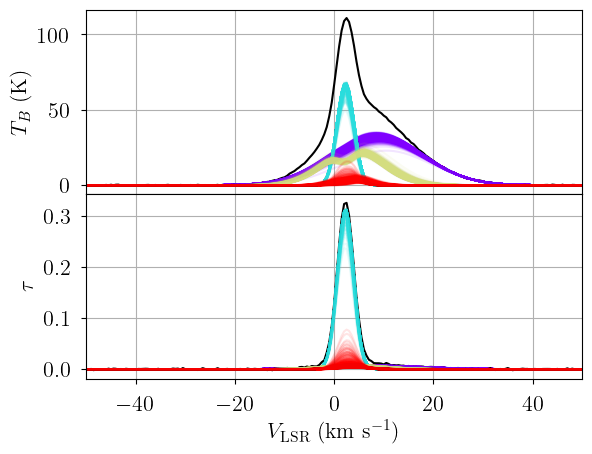

In [263]:
# plot
fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(synth_data["x_values_em"][idx], synth_data["data_list_em"][idx], "k-")
axes[1].plot(synth_data["x_values"][idx], synth_data["data_list"][idx], "k-")

# evaluate cloud-based contributions to data from posterior samples
colors = cm.rainbow(np.linspace(0, 1, best_n_gauss))
for i, color in enumerate(colors):
    cloud_tspin = trace["tspin"].data.copy()
    cloud_tspin[np.arange(best_n_gauss) != i] = 0.0
    predicted_emission = physics.radiative_transfer(
        emission_optical_depth,
        cloud_tspin.T,
        filling_factor,
        Tcmb,
    ).eval()
    predicted_absorption = absorption_optical_depth[:, :, i]
    axes[0].plot(synth_data["x_values_em"][idx], predicted_emission, "-", color=color, alpha=0.1)
    axes[1].plot(synth_data["x_values"][idx], predicted_absorption, "-", color=color, alpha=0.1)
axes[1].set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")
axes[0].set_ylabel(r"$T_B$ (K)")
axes[1].set_ylabel(r"$\tau$")
axes[0].set_xlim(-50.0, 50.0)
_ = fig.subplots_adjust(hspace=0)

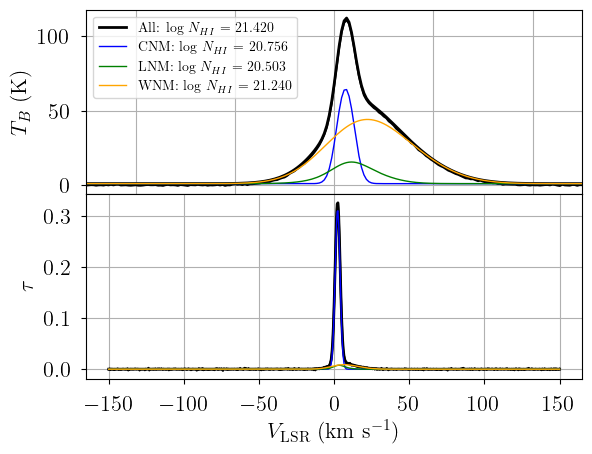

In [264]:
# plot actual decomposed spectrum
x, z = synth_data['location'][idx].astype(int)

fig, axes = plt.subplots(2)
axes[0].plot(synth_data["x_values_em"][idx], synth_data["data_list_em"][idx], "k-")
axes[1].plot(synth_data["x_values"][idx], synth_data["data_list"][idx], "k-")

for phase in sim_phases.keys():
    label = f"{phase}: " + r"log $N_{HI}$ = " + f"{np.log10(sim_phases[phase]['NHI'][x, z]):.3f}"
    axes[0].plot(synth_data["x_values_em"][idx], sim_phases[phase]["emission"][:, x, z], "-",
                color=sim_phases[phase]["color"], label=label, linewidth=2 if phase == "All" else 1)
    axes[1].plot(synth_data["x_values"][idx], sim_phases[phase]["absorption"][:, x, z], "-",
                color=sim_phases[phase]["color"], linewidth=2 if phase == "All" else 1)
axes[0].legend(loc="upper left", fontsize=10)
axes[1].set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")
axes[0].set_ylabel(r"$T_B$ (K)")
axes[1].set_ylabel(r"$\tau$")
axes[0].set_xlim(-50.0, 50.0)
_ = fig.subplots_adjust(hspace=0)

/tmp/ipykernel_487268/2624939774.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sim_phases[phase]["nHI"][x, :, z]), np.log10(sim_kin_temp[x, :, z]), "s",
/tmp/ipykernel_487268/2624939774.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xgrid, ygrid, pdf, colors=sim_phases[phase]["color"], origin='lower', alpha=0.5, levels=levels, label="caribou")


Text(0, 0.5, 'log$_{10}$ $T_K$ (K)')

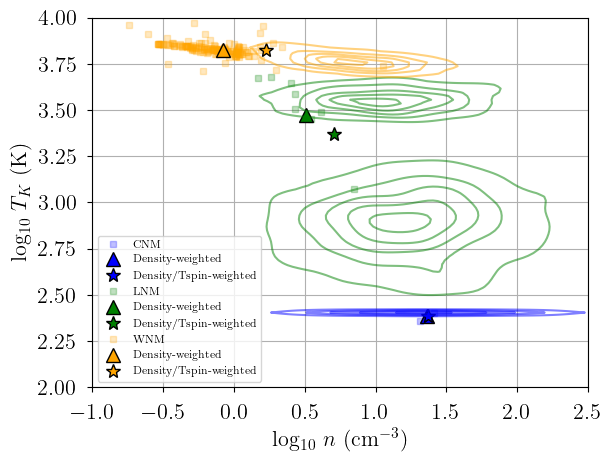

In [126]:
from scipy.stats import gaussian_kde

# compare actual physical properties with resulting clouds
extent = [-1.0, 2.5, 2.0, 4.0]
xgrid, ygrid = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:100j]
positions = np.vstack([xgrid.ravel(), ygrid.ravel()])

mean_tkin = np.mean(10.0**trace['log10_tkin'].data, axis=1)

fig, ax = plt.subplots()
for phase in sim_phases.keys():
    if phase == "All":
        continue
        
    # plot TIGRESS data
    ax.plot(np.log10(sim_phases[phase]["nHI"][x, :, z]), np.log10(sim_kin_temp[x, :, z]), "s",
            color=sim_phases[phase]["color"], label=phase, markersize=5, alpha=0.25)
    
    # TIGRESS density-weighted mean kinetic temp
    mean_nHI_1 = np.average(sim_phases[phase]["nHI"][x, :, z], weights=sim_phases[phase]["nHI"][x, :, z] > 0.0)
    mean_kin_temp_1 = np.average(sim_kin_temp[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z])
    
    # TIGRESS density/Tspin-weighted mean density and kinetic temperature
    mean_nHI_2 = np.average(sim_phases[phase]["nHI"][x, :, z], weights=sim_phases[phase]["nHI"][x, :, z]/sim_spin_temp[x, :, z])
    mean_kin_temp_2 = np.average(sim_kin_temp[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z]/sim_spin_temp[x, :, z])
    
    ax.plot(np.log10(mean_nHI_1), np.log10(mean_kin_temp_1), "^", color=sim_phases[phase]["color"],
            markersize=10, label="Density-weighted", markeredgecolor="k")
    ax.plot(np.log10(mean_nHI_2), np.log10(mean_kin_temp_2), "*", color=sim_phases[phase]["color"],
            markersize=10, label="Density/Tspin-weighted", markeredgecolor="k")
    
    # find clouds in this phase
    clouds = np.array([
        i for i in range(best_n_gauss)
        if (mean_tkin[i] > sim_phases[phase]["temp_min"]) and (mean_tkin[i] < sim_phases[phase]["temp_max"])
    ])
    for cloud in clouds:
        # generate KDE of posterior samples
        values = np.vstack([trace["log10_nHI"][cloud], trace["log10_tkin"][cloud]])
        kernel = gaussian_kde(values)
        pdf = np.reshape(kernel(positions).T, xgrid.shape)
        pdf = pdf/pdf.max()
        levels = np.arange(0.1, 1.0, 0.2)
        ax.contour(xgrid, ygrid, pdf, colors=sim_phases[phase]["color"], origin='lower', alpha=0.5, levels=levels, label="caribou")
ax.set_xlim(-1, 2.5)
ax.set_ylim(2, 4)
ax.legend(loc="lower left", fontsize=8)
ax.set_xlabel(r"log$_{10}$ $n$ (cm$^{-3}$)")
ax.set_ylabel(r"log$_{10}$ $T_K$ (K)")

/tmp/ipykernel_487268/2741592405.py:45: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xgrid, ygrid, pdf, colors=sim_phases[phase]["color"], origin='lower', alpha=0.5, levels=levels, label="caribou")


Text(0, 0.5, 'log$_{10}$ $T_K$ (K)')

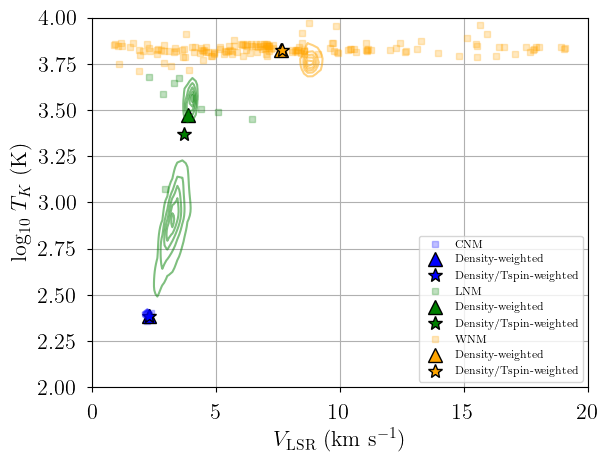

In [127]:
from scipy.stats import gaussian_kde

# compare actual physical properties with resulting clouds
extent = [0.0, 20.0, 2.0, 4.0]
xgrid, ygrid = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:100j]
positions = np.vstack([xgrid.ravel(), ygrid.ravel()])

mean_tkin = np.mean(10.0**trace['log10_tkin'].data, axis=1)

fig, ax = plt.subplots()
for phase in sim_phases.keys():
    if phase == "All":
        continue
        
    # plot TIGRESS data
    mask = sim_phases[phase]["nHI"][x, :, z] > 0.0
    ax.plot(sim_velocity[x, mask, z], np.log10(sim_kin_temp[x, mask, z]), "s",
            color=sim_phases[phase]["color"], label=phase, markersize=5, alpha=0.25)
    
    # TIGRESS density-weighted mean kinetic temp
    mean_velocity_1 = np.average(sim_velocity[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z] > 0.0)
    mean_kin_temp_1 = np.average(sim_kin_temp[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z])
    
    # TIGRESS density/Tspin-weighted mean density and kinetic temperature
    mean_velocity_2 = np.average(sim_velocity[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z]/sim_spin_temp[x, :, z])
    mean_kin_temp_2 = np.average(sim_kin_temp[x, :, z], weights=sim_phases[phase]["nHI"][x, :, z]/sim_spin_temp[x, :, z])
    
    ax.plot(mean_velocity_1, np.log10(mean_kin_temp_1), "^", color=sim_phases[phase]["color"],
            markersize=10, label="Density-weighted", markeredgecolor="k")
    ax.plot(mean_velocity_2, np.log10(mean_kin_temp_2), "*", color=sim_phases[phase]["color"],
            markersize=10, label="Density/Tspin-weighted", markeredgecolor="k")
    
    # find clouds in this phase
    clouds = np.array([
        i for i in range(best_n_gauss)
        if (mean_tkin[i] > sim_phases[phase]["temp_min"]) and (mean_tkin[i] < sim_phases[phase]["temp_max"])
    ])
    for cloud in clouds:
        # generate KDE of posterior samples
        values = np.vstack([trace["velocity"][cloud], trace["log10_tkin"][cloud]])
        kernel = gaussian_kde(values)
        pdf = np.reshape(kernel(positions).T, xgrid.shape)
        pdf = pdf/pdf.max()
        levels = np.arange(0.1, 1.0, 0.2)
        ax.contour(xgrid, ygrid, pdf, colors=sim_phases[phase]["color"], origin='lower', alpha=0.5, levels=levels, label="caribou")
ax.set_xlim(0, 20)
ax.set_ylim(2, 4)
ax.legend(loc="lower right", fontsize=8)
ax.set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")
ax.set_ylabel(r"log$_{10}$ $T_K$ (K)")

In [132]:
trace = results[idx]["results"][best_n_gauss]["solutions"][best_solution]["trace"]
trace

<xarray.Dataset> Size: 334kB
Dimensions:                   (chain: 8, draw: 100, baseline_coeff: 1, cloud: 4)
Coordinates:
  * chain                     (chain) int64 64B 0 1 2 3 4 5 6 7
  * draw                      (draw) int64 800B 0 10 20 30 ... 960 970 980 990
  * baseline_coeff            (baseline_coeff) int64 8B 0
  * cloud                     (cloud) int64 32B 0 1 2 3
Data variables: (12/16)
    baseline_absorption_norm  (chain, draw, baseline_coeff) float64 6kB -0.15...
    baseline_emission_norm    (chain, draw, baseline_coeff) float64 6kB -0.29...
    depth                     (chain, draw, cloud) float64 26kB 49.18 ... 3.411
    fwhm                      (chain, draw, cloud) float64 26kB 21.73 ... 8.148
    fwhm_nonthermal           (chain, draw, cloud) float64 26kB 14.36 ... 3.158
    fwhm_thermal              (chain, draw, cloud) float64 26kB 16.3 ... 7.511
    ...                        ...
    log10_n_alpha             (chain, draw, cloud) float64 26kB -5.321 ... -6...
    log10_tkin                (chain, draw, cloud) float64 26kB 3.764 ... 3.091
    rms_absorption            (chain, draw) float64 6kB 0.0009921 ... 0.001064
    rms_emission              (chain, draw) float64 6kB 0.1897 0.2026 ... 0.1874
    tspin                     (chain, draw, cloud) float64 26kB 5.591e+03 ......
    velocity                  (chain, draw, cloud) float64 26kB 8.684 ... 3.572
Attributes:
    created_at:     2024-09-21T08:52:36.109161+00:00
    arviz_version:  0.19.0

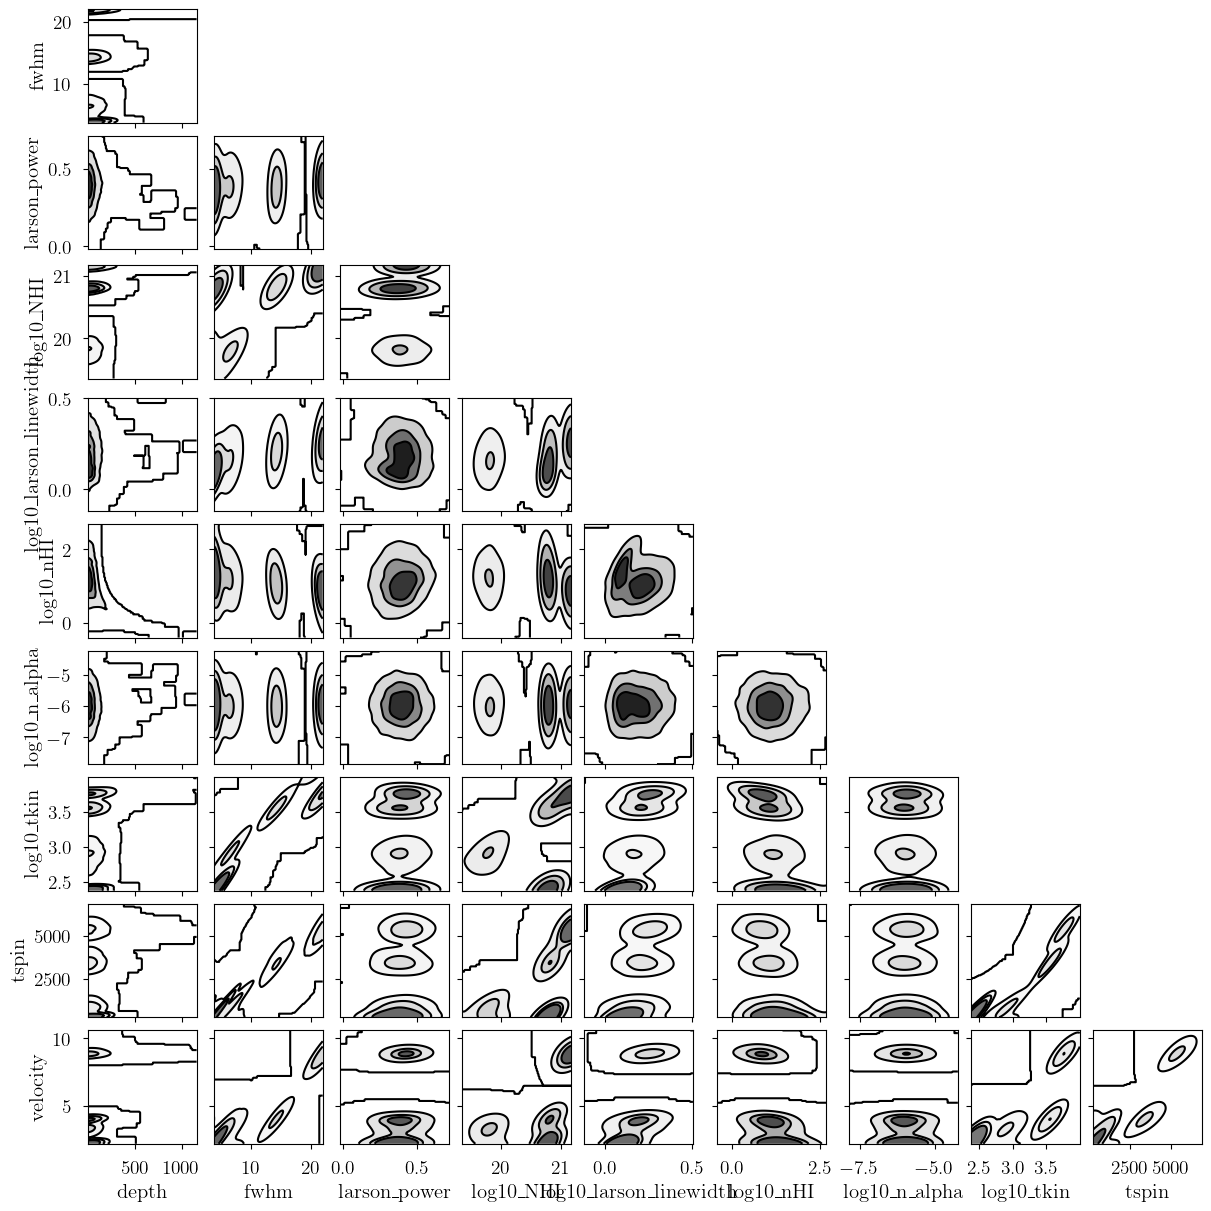

In [138]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_pair(
        trace,
        var_names=[
            "depth",
            "fwhm",
            "larson_power",
            "log10_NHI",
            "log10_larson_linewidth",
            "log10_nHI",
            "log10_n_alpha",
            "log10_tkin",
            "tspin",
            "velocity"
        ],
        combine_dims={"cloud"},
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],
                "contourf_kwargs": {"cmap": "Grays"},
                "contour_kwargs": {"colors": "k"},
            },
        backend_kwargs={"layout": "constrained"},
        figsize=(12,12),
    )

## Compile all results

In [146]:
trace['LNM_log10_NHI'] = np.log10((10.0**trace['log10_NHI'].sel(cloud=np.array([0, 1]))).sum(dim="cloud"))

In [154]:
trace["log10_NHI"].sel(cloud=np.array([0])).sum(dim="cloud")

<xarray.DataArray 'log10_NHI' (sample: 800)> Size: 6kB
array([20.04559049, 20.04869579, 20.05125656, 20.05065084, 20.04830442,
       20.04886178, 20.05781495, 20.0537983 , 20.05909131, 20.04761437,
       20.04057981, 20.05267098, 20.06610038, 20.03795622, 20.04466205,
       20.048158  , 20.06342584, 20.04621574, 20.04057306, 20.03946929,
       20.0479929 , 20.05707937, 20.04494626, 20.05714915, 20.04138676,
       20.04787648, 20.04598102, 20.03588835, 20.04359346, 20.03318281,
       20.04625675, 20.05549031, 20.04367127, 20.06159514, 20.04336966,
       20.04459693, 20.04127538, 20.04609624, 20.03902357, 20.05546212,
       20.05452245, 20.04308392, 20.04963906, 20.03830372, 20.03976506,
       20.05667456, 20.04261906, 20.03857122, 20.04541688, 20.04259483,
       20.04507064, 20.05929947, 20.05465516, 20.05139825, 20.04324608,
       20.05392834, 20.04812999, 20.03851106, 20.06368872, 20.03204557,
       20.04163296, 20.04799038, 20.0551347 , 20.054212  , 20.04187042,
       20.04799509, 20.04013721, 20.05224902, 20.04811288, 20.04691489,
       20.05880041, 20.03678292, 20.05970019, 20.05998954, 20.03504308,
       20.053702  , 20.0360034 , 20.05119208, 20.04933445, 20.0553847 ,
       20.02674787, 20.03188682, 20.03471268, 20.04258757, 20.0546366 ,
       20.04959918, 20.03123711, 20.03739928, 20.03890385, 20.05913831,
       20.04548099, 20.03218725, 20.04429898, 20.04666845, 20.05297557,
       20.04292505, 20.05514582, 20.05136214, 20.03716827, 20.04585754,
...
       20.04788603, 20.02753037, 20.03777942, 20.05722226, 20.04417271,
       20.04296045, 20.03453271, 20.032736  , 20.05019467, 20.0408439 ,
       20.03416372, 20.04714801, 20.05198128, 20.04538005, 20.04507411,
       20.03722104, 20.05945395, 20.04986744, 20.05118613, 20.05406651,
       20.04635158, 20.0365905 , 20.04407877, 20.05122751, 20.04616118,
       20.03872179, 20.05452555, 20.05969137, 20.04646379, 20.05551318,
       20.04637222, 20.03787538, 20.0470984 , 20.05855926, 20.03888849,
       20.05137696, 20.03149671, 20.04736497, 20.06357462, 20.05391506,
       20.03804377, 20.04668097, 20.06378003, 20.03771945, 20.04326481,
       20.05722784, 20.0638735 , 20.05859768, 20.05005083, 20.05094073,
       20.04465176, 20.04450271, 20.04667336, 20.02526557, 20.05098165,
       20.03761331, 20.06334492, 20.05100653, 20.03476028, 20.0522859 ,
       20.04628774, 20.05546625, 20.03516305, 20.03324525, 20.04705468,
       20.04600219, 20.02404901, 20.03929072, 20.04220511, 20.02819508,
       20.05288296, 20.04560338, 20.0520321 , 20.03773032, 20.05831737,
       20.04186143, 20.0545291 , 20.03022199, 20.02891072, 20.04391703,
       20.04568307, 20.0377562 , 20.04718412, 20.05136614, 20.04346429,
       20.05475757, 20.04788028, 20.06044431, 20.04861767, 20.04530867,
       20.04139908, 20.04010009, 20.04860254, 20.04906454, 20.04767785,
       20.05326558, 20.02799711, 20.05510282, 20.04155824, 20.05049779])
Coordinates:
  * sample   (sample) object 6kB MultiIndex
  * chain    (sample) int64 6kB 0 0 0 0 0 0 0 0 0 0 0 ... 7 7 7 7 7 7 7 7 7 7 7
  * draw     (sample) int64 6kB 0 10 20 30 40 50 60 ... 940 950 960 970 980 990

In [242]:
import os
import copy
from tqdm.notebook import tqdm
import warnings
import pickle

# sample random spectra for now
num_spectra = len(synth_data['location'])
sample_spectra = 10000
spectra_idx = np.random.choice(range(num_spectra), size=sample_spectra, replace=False)

results_template = {
    "All_log10_NHI": np.ones(num_spectra)*np.nan,
    "CNM_log10_NHI": np.ones(num_spectra)*np.nan,
    "LNM_log10_NHI": np.ones(num_spectra)*np.nan,
    "WNM_log10_NHI": np.ones(num_spectra)*np.nan,
    "CNM_fraction": np.ones(num_spectra)*np.nan,
    "All_spin_temp_n": np.ones(num_spectra)*np.nan,
    "All_spin_temp_nT": np.ones(num_spectra)*np.nan,
    "CNM_spin_temp_n": np.ones(num_spectra)*np.nan,
    "CNM_spin_temp_nT": np.ones(num_spectra)*np.nan,
    "LNM_spin_temp_n": np.ones(num_spectra)*np.nan,
    "LNM_spin_temp_nT": np.ones(num_spectra)*np.nan,
    "WNM_spin_temp_n": np.ones(num_spectra)*np.nan,
    "WNM_spin_temp_nT": np.ones(num_spectra)*np.nan,
    "BIC": np.ones(num_spectra)*np.nan,
    "n_gauss": np.zeros(num_spectra, dtype=int),
    "n_solutions": np.zeros(num_spectra, dtype=int),
}
all_results = {
    "tigress": copy.deepcopy(results_template),
    "caribou_mean": copy.deepcopy(results_template),
    "caribou_sd": copy.deepcopy(results_template),
    "caribou_hdi3": copy.deepcopy(results_template),
    "caribou_hdi97": copy.deepcopy(results_template),
}

pbar = tqdm(total=sample_spectra)

with warnings.catch_warnings(action="ignore"):
    for idx in spectra_idx:
        pbar.update()
        
        if not os.path.exists(f"{resultsdir}/HI_joint_spectra_results/{idx}_pencilbeam.pkl"):
            continue

        with open(f"{resultsdir}/HI_joint_spectra_results/{idx}_pencilbeam.pkl", "rb") as f:
            result = dill.load(f)

            # get best model
            best_bic = np.inf
            best_n_gauss = 0
            best_solution = None
            for n_gauss in result["results"].keys():
                bic = np.nan
                max_rhat = np.nan
                if "bic" in result["results"][n_gauss]:
                    bic = result["results"][n_gauss]["bic"]
                max_rhat = np.nan
                if "solutions" in result["results"][n_gauss].keys():
                    for solution in result["results"][n_gauss]["solutions"].keys():
                        if result["results"][n_gauss]["solutions"][solution]["bic"] == bic:
                            max_rhat = result["results"][n_gauss]["solutions"][solution]["summary"]["r_hat"].max()
                            break
                if bic < (best_bic - 10.0) and max_rhat < 1.05:
                    best_n_gauss = n_gauss
                    best_bic = bic
                    best_solution = solution

            # save TIGRESS results
            x, z = synth_data['location'][idx].astype(int)
            for phase in sim_phases.keys():
                all_results["tigress"][f"{phase}_log10_NHI"][idx] = np.log10(sim_phases[phase]["NHI"][x, z])
                weights_n = sim_phases[phase]["nHI"][x, :, z]
                if weights_n.sum() > 0:
                    all_results["tigress"][f"{phase}_spin_temp_n"][idx] = np.average(sim_spin_temp[x, :, z], weights=weights_n)
                weights_nT = sim_phases[phase]["nHI"][x, :, z]/sim_spin_temp[x, :, z]
                if weights_nT.sum() > 0:
                    all_results["tigress"][f"{phase}_spin_temp_nT"][idx] = np.average(sim_spin_temp[x, :, z], weights=weights_nT)
            all_results["tigress"]["CNM_fraction"][idx] = 10.0**all_results["tigress"]["CNM_log10_NHI"][idx]/10.0**all_results["tigress"]["All_log10_NHI"][idx]

            # add caribou derived quantities to trace, save caribou results
            all_results["caribou_mean"]["BIC"][idx] = best_bic
            all_results["caribou_mean"]["n_gauss"][idx] = best_n_gauss
            if "solutions" in result["results"][best_n_gauss].keys():
                all_results["caribou_mean"]["n_solutions"][idx] = len(result["results"][best_n_gauss]["solutions"])

            if best_solution is None:
                continue

            trace = result["results"][best_n_gauss]["solutions"][best_solution]["trace"]
            mean_tkin = (10.0**trace['log10_tkin']).mean(dim=["chain", "draw"])
            for phase in sim_phases.keys():
                # find clouds in this phase
                clouds = np.array([
                    i for i in range(best_n_gauss)
                    if (mean_tkin[i] > sim_phases[phase]["temp_min"]) and (mean_tkin[i] < sim_phases[phase]["temp_max"])
                ])
                trace[f"{phase}_log10_NHI"] = np.log10((10.0**trace["log10_NHI"].sel(cloud=clouds)).sum(dim="cloud"))
                weights_n = 10.0**trace["log10_NHI"].sel(cloud=clouds)
                weights_nT = (10.0**trace["log10_NHI"] / trace["tspin"]).sel(cloud=clouds)
                trace[f"{phase}_spin_temp_n"] = (weights_n * trace["tspin"].sel(cloud=clouds)).sum(dim="cloud") / weights_n.sum(dim="cloud")
                trace[f"{phase}_spin_temp_nT"] = (weights_nT * trace["tspin"].sel(cloud=clouds)).sum(dim="cloud") / weights_nT.sum(dim="cloud")

                summary = az.summary(trace, var_names=[f"{phase}_log10_NHI", f"{phase}_spin_temp_n", f"{phase}_spin_temp_nT"])

                all_results["caribou_mean"][f"{phase}_log10_NHI"][idx] = summary["mean"][f"{phase}_log10_NHI"]
                all_results["caribou_sd"][f"{phase}_log10_NHI"][idx] = summary["sd"][f"{phase}_log10_NHI"]
                all_results["caribou_hdi3"][f"{phase}_log10_NHI"][idx] = summary["hdi_3%"][f"{phase}_log10_NHI"]
                all_results["caribou_hdi97"][f"{phase}_log10_NHI"][idx] = summary["hdi_97%"][f"{phase}_log10_NHI"]

                all_results["caribou_mean"][f"{phase}_spin_temp_n"][idx] = summary["mean"][f"{phase}_spin_temp_n"]
                all_results["caribou_sd"][f"{phase}_spin_temp_n"][idx] = summary["sd"][f"{phase}_spin_temp_n"]
                all_results["caribou_hdi3"][f"{phase}_spin_temp_n"][idx] = summary["hdi_3%"][f"{phase}_spin_temp_n"]
                all_results["caribou_hdi97"][f"{phase}_spin_temp_n"][idx] = summary["hdi_97%"][f"{phase}_spin_temp_n"]

                all_results["caribou_mean"][f"{phase}_spin_temp_nT"][idx] = summary["mean"][f"{phase}_spin_temp_nT"]
                all_results["caribou_sd"][f"{phase}_spin_temp_nT"][idx] = summary["sd"][f"{phase}_spin_temp_nT"]
                all_results["caribou_hdi3"][f"{phase}_spin_temp_nT"][idx] = summary["hdi_3%"][f"{phase}_spin_temp_nT"]
                all_results["caribou_hdi97"][f"{phase}_spin_temp_nT"][idx] = summary["hdi_97%"][f"{phase}_spin_temp_nT"]

            trace["CNM_fraction"] = 10.0**trace["CNM_log10_NHI"] / 10.0**trace["All_log10_NHI"]

            summary = az.summary(trace, var_names=["CNM_fraction"])

            all_results["caribou_mean"]["CNM_fraction"][idx] = summary["mean"]["CNM_fraction"]
            all_results["caribou_sd"]["CNM_fraction"][idx] = summary["sd"]["CNM_fraction"]
            all_results["caribou_hdi3"]["CNM_fraction"][idx] = summary["hdi_3%"]["CNM_fraction"]
            all_results["caribou_hdi97"]["CNM_fraction"][idx] = summary["hdi_97%"]["CNM_fraction"]


  0%|          | 0/10000 [00:00<?, ?it/s]

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains

Text(0, 0.5, '\\texttt{caribou_hi} $f_{\\rm CNM}$')

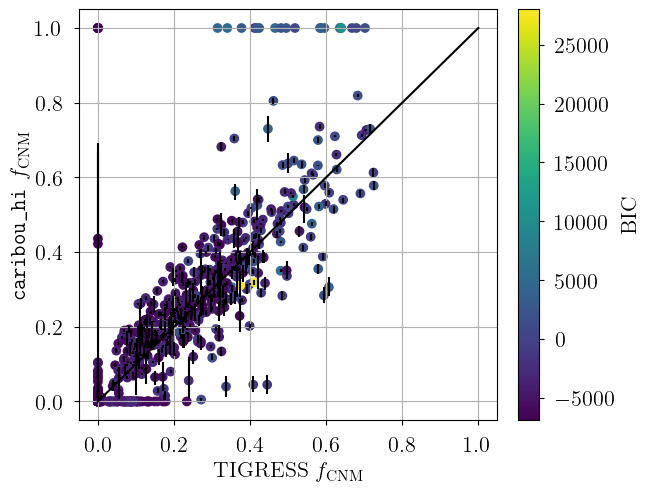

In [244]:
# plot CNM fraction colored by BIC
fig, ax = plt.subplots(layout="constrained")
yerr = [
    all_results["caribou_mean"]["CNM_fraction"] - all_results["caribou_hdi3"]["CNM_fraction"],
    all_results["caribou_hdi97"]["CNM_fraction"] - all_results["caribou_mean"]["CNM_fraction"],
]
cax = ax.scatter(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    c=all_results["caribou_mean"]["BIC"],
    marker="o",
)
cbar = fig.colorbar(cax)
cbar.set_label("BIC")
ax.errorbar(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    yerr=yerr,
    marker=None,
    linestyle="",
    color="k",
)
ax.plot([0.0, 1.0], [0.0, 1.0], "k-")
ax.set_xlabel(r"TIGRESS $f_{\rm CNM}$")
ax.set_ylabel(r"\texttt{caribou_hi} $f_{\rm CNM}$")

Text(0, 0.5, '\\texttt{caribou_hi} $f_{\\rm CNM}$')

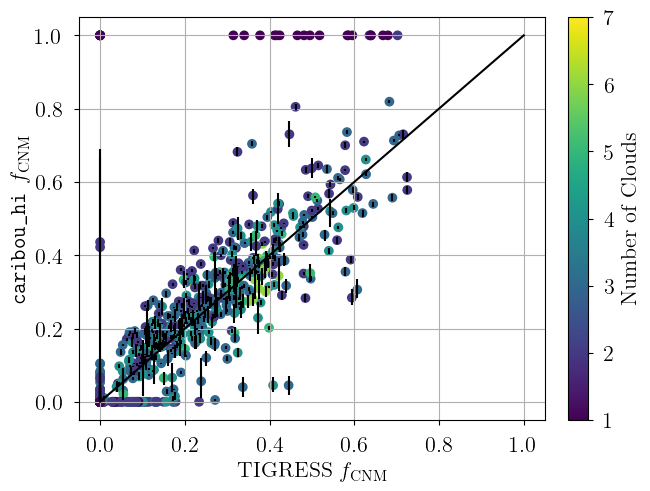

In [245]:
# plot CNM fraction colored by n_gauss
fig, ax = plt.subplots(layout="constrained")
yerr = [
    all_results["caribou_mean"]["CNM_fraction"] - all_results["caribou_hdi3"]["CNM_fraction"],
    all_results["caribou_hdi97"]["CNM_fraction"] - all_results["caribou_mean"]["CNM_fraction"],
]
cax = ax.scatter(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    c=all_results["caribou_mean"]["n_gauss"],
    marker="o",
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Clouds")
ax.errorbar(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    yerr=yerr,
    marker=None,
    linestyle="",
    color="k",
)
ax.plot([0.0, 1.0], [0.0, 1.0], "k-")
ax.set_xlabel(r"TIGRESS $f_{\rm CNM}$")
ax.set_ylabel(r"\texttt{caribou_hi} $f_{\rm CNM}$")

Text(0, 0.5, '\\texttt{caribou_hi} $f_{\\rm CNM}$')

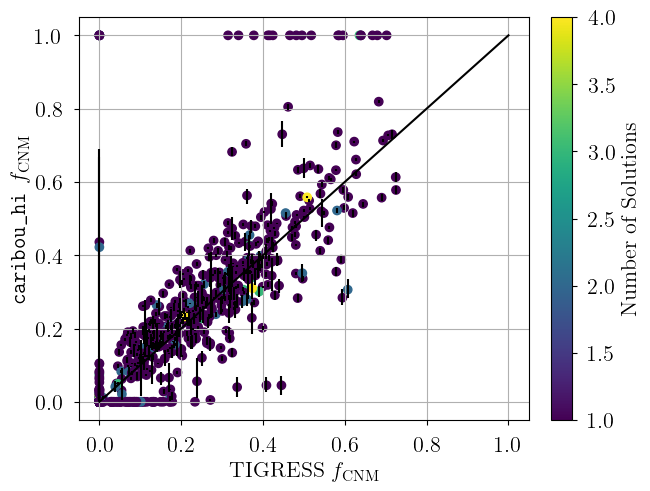

In [246]:
# plot CNM fraction colored by n_solutions
fig, ax = plt.subplots(layout="constrained")
yerr = [
    all_results["caribou_mean"]["CNM_fraction"] - all_results["caribou_hdi3"]["CNM_fraction"],
    all_results["caribou_hdi97"]["CNM_fraction"] - all_results["caribou_mean"]["CNM_fraction"],
]
cax = ax.scatter(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    c=all_results["caribou_mean"]["n_solutions"],
    marker="o",
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Solutions")
ax.errorbar(
    all_results["tigress"]["CNM_fraction"],
    all_results["caribou_mean"]["CNM_fraction"],
    yerr=yerr,
    marker=None,
    linestyle="",
    color="k",
)
ax.plot([0.0, 1.0], [0.0, 1.0], "k-")
ax.set_xlabel(r"TIGRESS $f_{\rm CNM}$")
ax.set_ylabel(r"\texttt{caribou_hi} $f_{\rm CNM}$")

/tmp/ipykernel_487268/2785898357.py:5: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
/tmp/ipykernel_487268/2785898357.py:6: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],


Text(0, 0.5, '\\texttt{caribou_hi} log$_{10}$ $N_{\\rm HI}$ (cm$^{-2}$)')

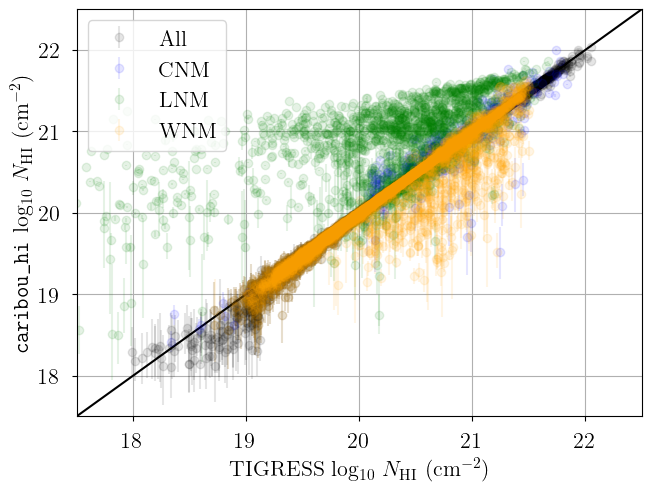

In [266]:
# plot column densities
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    yerr = [
        all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
        all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        yerr=yerr,
        marker="o",
        linestyle="",
        color=sim_phases[phase]["color"],
        label=phase,
        alpha=0.1,
    )
ax.legend(loc="upper left")
ax.plot([17.5, 22.5], [17.5, 22.5], "k-")
ax.set_xlim(17.5, 22.5)
ax.set_ylim(17.5, 22.5)
ax.set_xlabel(r"TIGRESS log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")
ax.set_ylabel(r"\texttt{caribou_hi} log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")

/tmp/ipykernel_487268/315701342.py:15: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
/tmp/ipykernel_487268/315701342.py:16: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],


Text(0, 0.5, '\\texttt{caribou_hi} log$_{10}$ $N_{\\rm HI}$ (cm$^{-2}$)')

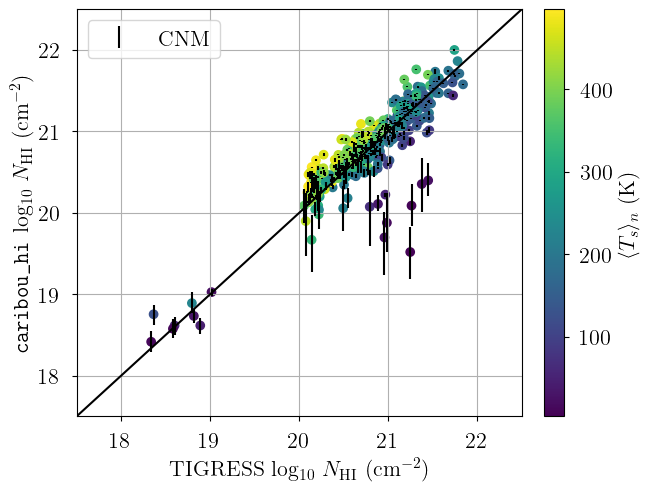

In [267]:
# plot CNM column density colored by density-weighted spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "CNM":
        continue
    cax = ax.scatter(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        c=all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        marker="o",
    )
    cbar = fig.colorbar(cax)
    cbar.set_label(r"$\langle T_s \rangle_{n}$ (K)")
    yerr = [
        all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
        all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        yerr=yerr,
        marker=None,
        linestyle="",
        color="k",
        label=phase,
    )
ax.legend(loc="upper left")
ax.plot([17.5, 22.5], [17.5, 22.5], "k-")
ax.set_xlim(17.5, 22.5)
ax.set_ylim(17.5, 22.5)
ax.set_xlabel(r"TIGRESS log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")
ax.set_ylabel(r"\texttt{caribou_hi} log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")

/tmp/ipykernel_487268/1013887290.py:15: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
/tmp/ipykernel_487268/1013887290.py:16: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],


Text(0, 0.5, '\\texttt{caribou_hi} log$_{10}$ $N_{\\rm HI}$ (cm$^{-2}$)')

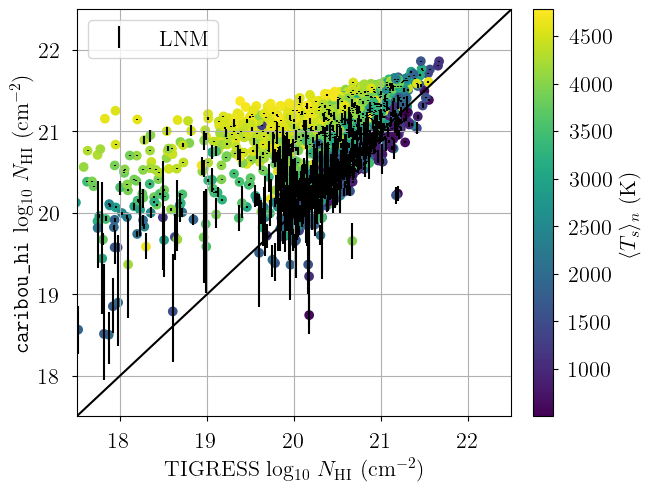

In [268]:
# plot LNM column density colored by density-weighted spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "LNM":
        continue
    cax = ax.scatter(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        c=all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        marker="o",
    )
    cbar = fig.colorbar(cax)
    cbar.set_label(r"$\langle T_s \rangle_{n}$ (K)")
    yerr = [
        all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
        all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        yerr=yerr,
        marker=None,
        linestyle="",
        color="k",
        label=phase,
    )
ax.legend(loc="upper left")
ax.plot([17.5, 22.5], [17.5, 22.5], "k-")
ax.set_xlim(17.5, 22.5)
ax.set_ylim(17.5, 22.5)
ax.set_xlabel(r"TIGRESS log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")
ax.set_ylabel(r"\texttt{caribou_hi} log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")

/tmp/ipykernel_487268/2843895135.py:17: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
/tmp/ipykernel_487268/2843895135.py:18: RuntimeWarning: invalid value encountered in subtract
  all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],


Text(0, 0.5, '\\texttt{caribou_hi} log$_{10}$ $N_{\\rm HI}$ (cm$^{-2}$)')

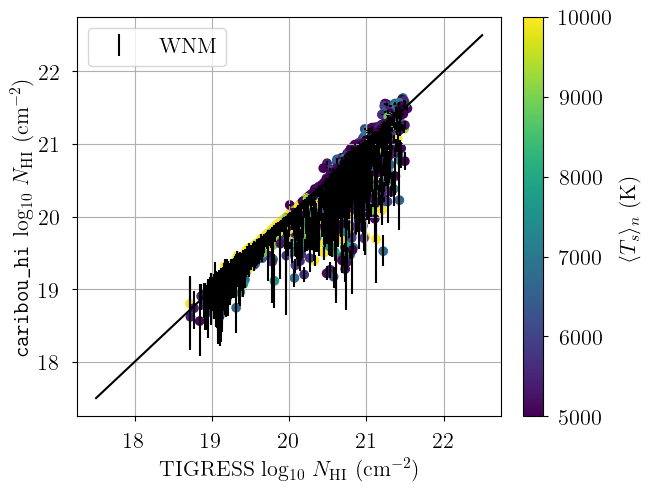

In [250]:
# plot WNM column density colored by density-weighted spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "WNM":
        continue
    cax = ax.scatter(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        c=all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        marker="o",
        vmin=5000.0,
        vmax=10000.0,
    )
    cbar = fig.colorbar(cax)
    cbar.set_label(r"$\langle T_s \rangle_{n}$ (K)")
    yerr = [
        all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
        all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        yerr=yerr,
        marker=None,
        linestyle="",
        color="k",
        label=phase,
    )
ax.legend(loc="upper left")
ax.plot([17.5, 22.5], [17.5, 22.5], "k-")
ax.set_xlabel(r"TIGRESS log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")
ax.set_ylabel(r"\texttt{caribou_hi} log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")

Text(0, 0.5, '\\texttt{caribou_hi} log$_{10}$ $N_{\\rm HI}$ (cm$^{-2}$)')

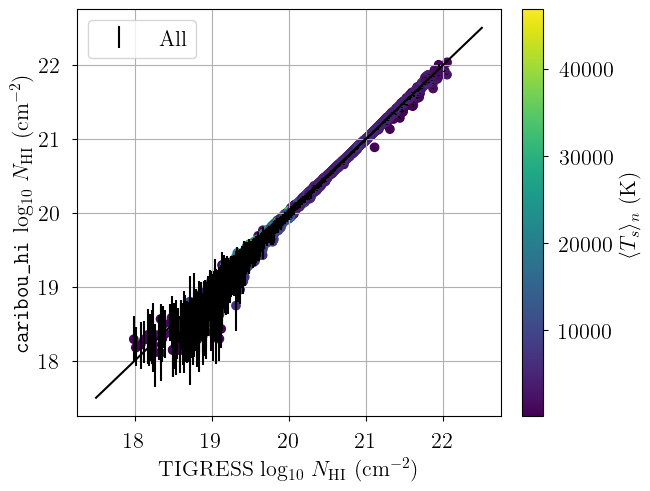

In [251]:
# plot All column density colored by density-weighted spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "All":
        continue
    cax = ax.scatter(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        c=all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        marker="o",
    )
    cbar = fig.colorbar(cax)
    cbar.set_label(r"$\langle T_s \rangle_{n}$ (K)")
    yerr = [
        all_results["caribou_mean"][f"{phase}_log10_NHI"] - all_results["caribou_hdi3"][f"{phase}_log10_NHI"],
        all_results["caribou_hdi97"][f"{phase}_log10_NHI"] - all_results["caribou_mean"][f"{phase}_log10_NHI"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_log10_NHI"],
        all_results["caribou_mean"][f"{phase}_log10_NHI"],
        yerr=yerr,
        marker=None,
        linestyle="",
        color="k",
        label=phase,
    )
ax.legend(loc="upper left")
ax.plot([17.5, 22.5], [17.5, 22.5], "k-")
ax.set_xlabel(r"TIGRESS log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")
ax.set_ylabel(r"\texttt{caribou_hi} log$_{10}$ $N_{\rm HI}$ (cm$^{-2}$)")

Text(0, 0.5, '\\texttt{caribou_hi} $\\langle T_s \\rangle_{n}$ (K)')

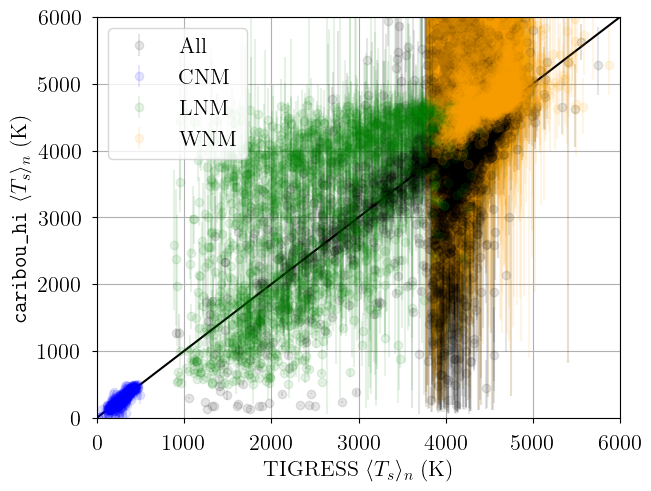

In [259]:
# plot density-weighted mean spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    yerr = [
        all_results["caribou_mean"][f"{phase}_spin_temp_n"] - all_results["caribou_hdi3"][f"{phase}_spin_temp_n"],
        all_results["caribou_hdi97"][f"{phase}_spin_temp_n"] - all_results["caribou_mean"][f"{phase}_spin_temp_n"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_spin_temp_n"],
        all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        yerr=yerr,
        marker="o",
        linestyle="",
        color=sim_phases[phase]["color"],
        label=phase,
        alpha=0.1,
    )
ax.legend(loc="upper left")
ax.plot([0.0, 6000.0], [0.0, 6000.0], "k-")
ax.set_xlim(0.0, 6000.0)
ax.set_ylim(0.0, 6000.0)
ax.set_xlabel(r"TIGRESS $\langle T_s \rangle_{n}$ (K)")
ax.set_ylabel(r"\texttt{caribou_hi} $\langle T_s \rangle_{n}$ (K)")

Text(0, 0.5, '\\texttt{caribou_hi} $\\langle T_s \\rangle_{n/T}$ (K)')

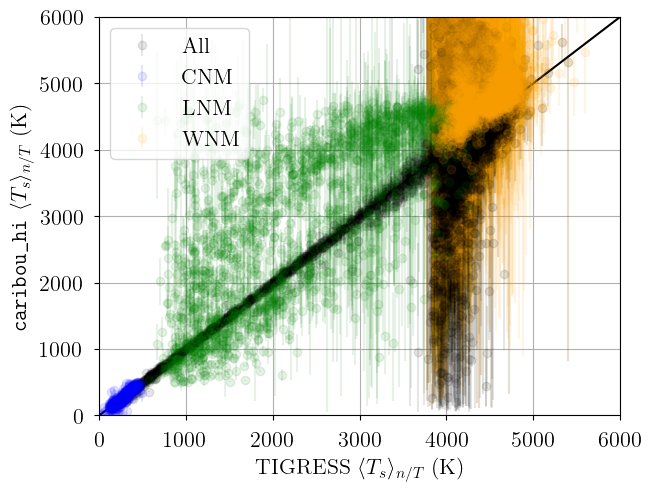

In [258]:
# plot density/Tspin-weighted mean spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    yerr = [
        all_results["caribou_mean"][f"{phase}_spin_temp_nT"] - all_results["caribou_hdi3"][f"{phase}_spin_temp_nT"],
        all_results["caribou_hdi97"][f"{phase}_spin_temp_nT"] - all_results["caribou_mean"][f"{phase}_spin_temp_nT"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_spin_temp_nT"],
        all_results["caribou_mean"][f"{phase}_spin_temp_nT"],
        yerr=yerr,
        marker="o",
        linestyle="",
        color=sim_phases[phase]["color"],
        label=phase,
        alpha=0.1,
    )
ax.legend(loc="upper left")
ax.plot([0.0, 6000.0], [0.0, 6000.0], "k-")
ax.set_xlim(0.0, 6000.0)
ax.set_ylim(0.0, 6000.0)
ax.set_xlabel(r"TIGRESS $\langle T_s \rangle_{n/T}$ (K)")
ax.set_ylabel(r"\texttt{caribou_hi} $\langle T_s \rangle_{n/T}$ (K)")

Text(0, 0.5, '\\texttt{caribou_hi} $\\langle T_s \\rangle_{n}$ (K)')

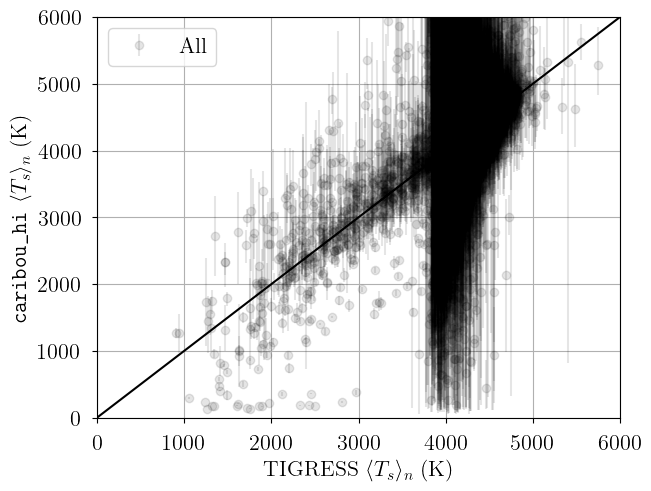

In [256]:
# plot All density-weighted mean spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "All":
        continue
    yerr = [
        all_results["caribou_mean"][f"{phase}_spin_temp_n"] - all_results["caribou_hdi3"][f"{phase}_spin_temp_n"],
        all_results["caribou_hdi97"][f"{phase}_spin_temp_n"] - all_results["caribou_mean"][f"{phase}_spin_temp_n"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_spin_temp_n"],
        all_results["caribou_mean"][f"{phase}_spin_temp_n"],
        yerr=yerr,
        marker="o",
        linestyle="",
        color=sim_phases[phase]["color"],
        label=phase,
        alpha=0.1,
    )
ax.legend(loc="upper left")
ax.plot([0.0, 6000.0], [0.0, 6000.0], "k-")
ax.set_xlim(0.0, 6000.0)
ax.set_ylim(0.0, 6000.0)
ax.set_xlabel(r"TIGRESS $\langle T_s \rangle_{n}$ (K)")
ax.set_ylabel(r"\texttt{caribou_hi} $\langle T_s \rangle_{n}$ (K)")

Text(0, 0.5, '\\texttt{caribou_hi} $\\langle T_s \\rangle_{n/T}$ (K)')

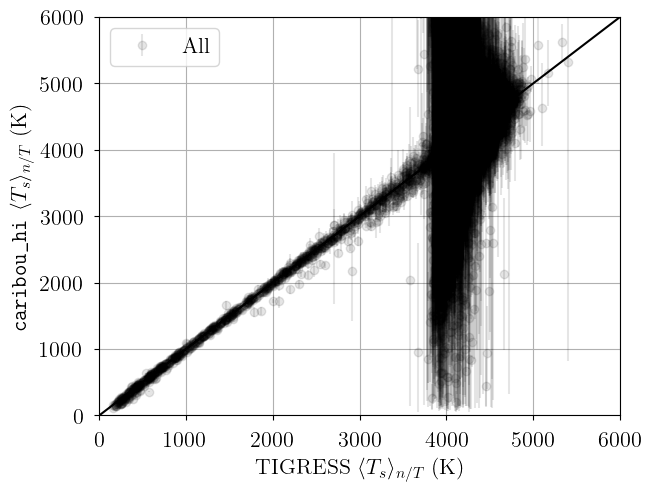

In [257]:
# plot All density/Tspin-weighted mean spin temperature
fig, ax = plt.subplots(layout="constrained")
for phase in sim_phases.keys():
    if phase != "All":
        continue
    yerr = [
        all_results["caribou_mean"][f"{phase}_spin_temp_nT"] - all_results["caribou_hdi3"][f"{phase}_spin_temp_nT"],
        all_results["caribou_hdi97"][f"{phase}_spin_temp_nT"] - all_results["caribou_mean"][f"{phase}_spin_temp_nT"],
    ]
    ax.errorbar(
        all_results["tigress"][f"{phase}_spin_temp_nT"],
        all_results["caribou_mean"][f"{phase}_spin_temp_nT"],
        yerr=yerr,
        marker="o",
        linestyle="",
        color=sim_phases[phase]["color"],
        label=phase,
        alpha=0.1,
    )
ax.legend(loc="upper left")
ax.plot([0.0, 6000.0], [0.0, 6000.0], "k-")
ax.set_xlim(0.0, 6000.0)
ax.set_ylim(0.0, 6000.0)
ax.set_xlabel(r"TIGRESS $\langle T_s \rangle_{n/T}$ (K)")
ax.set_ylabel(r"\texttt{caribou_hi} $\langle T_s \rangle_{n/T}$ (K)")